In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, confusion_matrix, ConfusionMatrixDisplay
from hmmlearn import hmm
import pickle

sns.set_theme(style='white')
sns.color_palette('bright')
%matplotlib inline
plt.rcParams['figure.dpi'] = 140

In [2]:
data = pd.read_csv('./Abeni_data/Data_Abeni.csv')

In [3]:
signals = [
    'Accelerator_Pedal_value',
    'Throttle_position_signal',
    'Intake_air_pressure',
    'Absolute_throttle_position',
    'Engine_speed',
    'Engine_torque',
]

In [4]:
data = data.loc[:, signals]

In [5]:
data.head(10)

,Accelerator_Pedal_value,Throttle_position_signal,Intake_air_pressure,Absolute_throttle_position,Engine_speed,Engine_torque
0,0.0,5.2,33.0,13.3,929.0,5.5
1,0.0,6.1,40.0,13.7,726.0,7.0
2,0.0,5.2,41.0,13.7,685.0,7.0
3,0.0,4.7,38.0,13.3,675.0,7.0
4,0.0,5.7,40.0,13.7,716.0,8.2
5,0.0,5.7,41.0,13.7,740.0,9.0
6,0.0,5.7,42.0,13.7,682.0,11.7
7,0.0,6.6,52.0,14.5,670.0,16.8
8,0.0,7.1,60.0,14.5,655.0,21.5
9,0.0,7.1,65.0,14.9,648.0,23.8


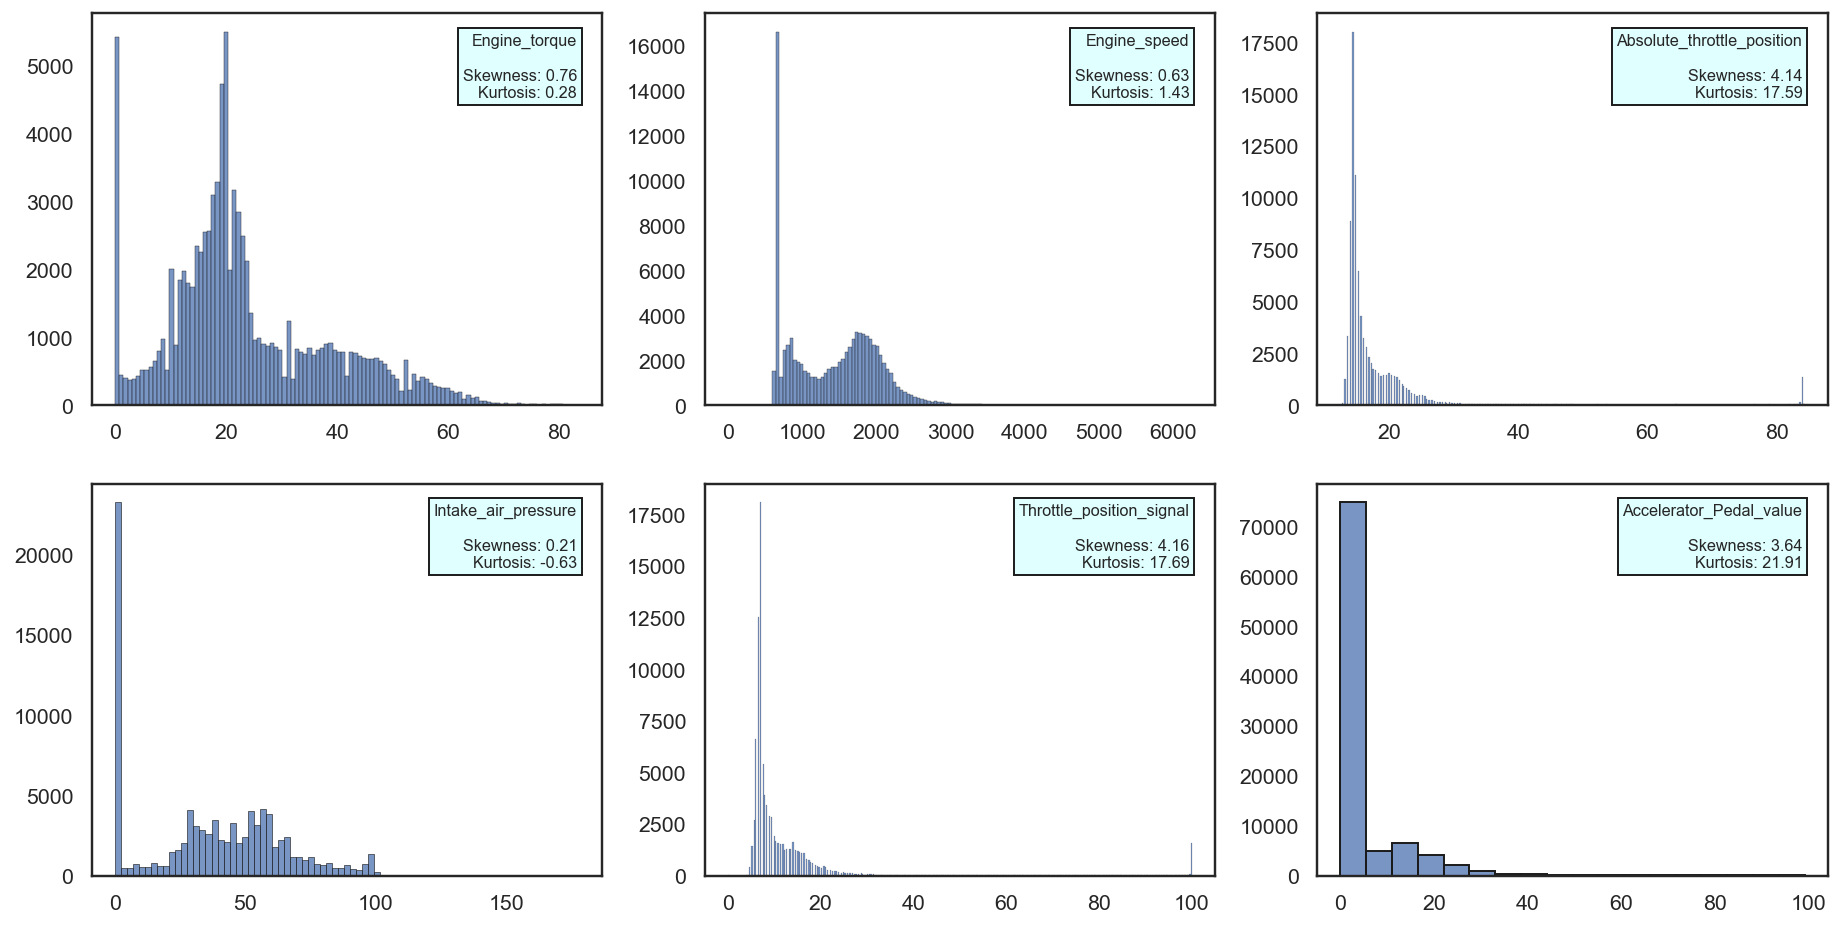

In [5]:
# place 9 features in 3x3 grid
f, axs = plt.subplots(2, 3, figsize=(4*4, 2*4))

signals_copy = signals.copy()
for i in range(axs.shape[0]):
    for j in range(axs.shape[1]):

        if signals_copy: 
            curr_sig = signals_copy.pop()
    
            skew, kurt = data[curr_sig].skew(), data[curr_sig].kurt()
            sns.histplot(data[curr_sig], ax=axs[i][j], edgecolor='k')

            axs[i][j].set_xlabel('')
            axs[i][j].set_ylabel('')
            axs[i][j].text(.95, .95, f'{curr_sig}\n\nSkewness: {skew:.2f}\nKurtosis: {kurt:.2f}', 
                                    horizontalalignment='right',
                                    verticalalignment = 'top',
                                    fontsize='x-small',
                                    bbox=dict(boxstyle='square', facecolor='lightcyan', edgecolor='k'),
                                    transform=axs[i][j].transAxes) 

In [55]:
x_train, x_test = train_test_split(data, test_size=.2, shuffle=False)
y_test = pd.Series([0]*x_test.shape[0], index=x_test.index, name='Flag')

In [56]:
# inject the attacks

idx_throttle = x_test[x_test['Throttle_position_signal']<10][::100].index

x_test_attack = x_test.copy()
y_test_attack = y_test.copy()

for i in idx_throttle:

    x_test_attack.loc[i:i+20, 'Throttle_position_signal'] = 70
    y_test_attack.loc[i:i+20] = 1

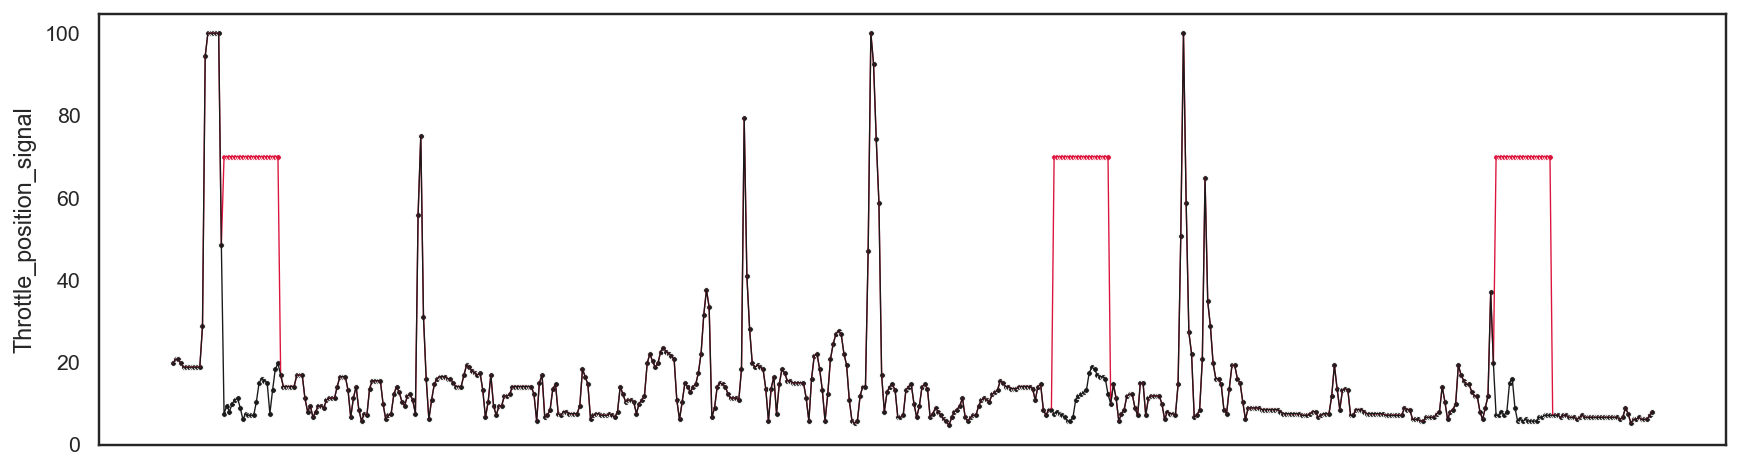

In [80]:
n=550

subsetX = x_test[:n]
subsetY = y_test[:n]

attack_subsetX = x_test_attack[:n]
attack_subsetY = y_test_attack[:n]

f, axs = plt.subplots(figsize=(15, 4))

# attack
ax=sns.scatterplot(x=attack_subsetX.index, y=attack_subsetX['Throttle_position_signal'], marker='.', color='crimson')
sns.lineplot(x=attack_subsetX.index, y=attack_subsetX['Throttle_position_signal'], lw=.7, color='crimson')

# normal
ax=sns.scatterplot(x=subsetX.index, y=subsetX['Throttle_position_signal'], marker='.', color='k')
sns.lineplot(x=subsetX.index, y=subsetX['Throttle_position_signal'], lw=.7, color='k')

_ = ax.set_xticklabels([])

In [9]:
def sliding_window_logprobs(model, sequence, w_length, threshold):
    # initialize boundaries of the sliding window
    start = 0
    end = start + w_length

    # initialize list of resulting probabilities and predicted attacks
    log_probs = []
    y_pred = []

    for _ in sequence:
        window = sequence[start:end, :]
        curr_log = model.score(window)
        log_probs.append(curr_log)

        if curr_log < threshold:
            y_pred.append(1)
        else:
            y_pred.append(0)


        start += 1
        end += 1
    
    return log_probs, y_pred

In [10]:
x_train_np = x_train.values

x_test_np = x_test_attack.values
y_test_np = y_test_attack.values

In [11]:
# Gaussian model
gmodel_params = {
    'cov_type': ['diag', 'full', 'tied'],
    'n_components': [2, 3, 5]
}

glog_params = {
    'w_length': [2, 3, 5],
    'thresholds': [-250, -270, -300, -350]
}

gmodels = []

In [12]:
# # Parameters tuning

# # train models
# print('Training models...')
# for cov_type in gmodel_params['cov_type']:
#     for n_components in gmodel_params['n_components']:

#             gmodels.append(hmm.GaussianHMM(n_components=n_components, 
#                                     covariance_type=cov_type).fit(x_train_np))

# print('Calculating probabilities...')
# # calculate f1 score for different params on test set for the trained models
# gscores = {one_model: {'w_length':None, 'threshold':None, 'score': 0}
#             for one_model in gmodels}

# for one_model in gscores.keys():
#     f1_curr = gscores[one_model]['score']

#     for w_length in glog_params['w_length']:

#             log_probs = sliding_window_logprobs(one_model, x_test_np, w_length)
        
#             for threshold in glog_params['thresholds']:

#                 y_pred = pd.Series([1 if one_prob < threshold else 0
#                                         for one_prob in log_probs],
#                                         index=y_test_attack.index)

#                 f1 = f1_score(y_test_attack, y_pred, labels=[0, 1])

#                 if f1 > f1_curr:
#                     f1_curr = f1
#                     gscores[one_model]['score'] = f1_curr
#                     gscores[one_model]['threshold'] = threshold
#                     gscores[one_model]['w_length'] = w_length

# print('Choosing the best model...')
# # Find the best model and the best params for it
# best_score = 0
# best_model = None
# best_w_length = None
# best_threshold = None

# for one_model in gscores:
#     if gscores[one_model]['score'] > best_score:

#         best_score = gscores[one_model]['score']
#         best_model = one_model
#         best_w_length = gscores[one_model]['w_length']
#         best_threshold = gscores[one_model]['threshold']

# print('\n')
# print(f'Best model: {best_model}')
# print(f'Best score: {best_score}')
# print(f'Best w_length: {best_w_length}')
# print(f'Best threshold: {best_threshold}')

In [13]:
model = hmm.GaussianHMM(covariance_type='full', n_components=3).fit(x_train_np)
best_w_length = 3
best_threshold = -350

f1 plateau: 0.9762962962962963


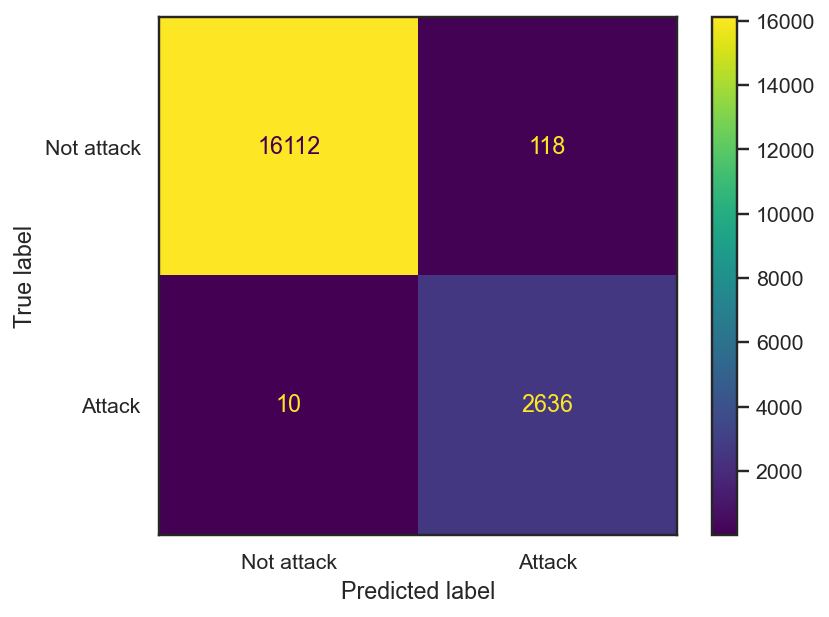

In [14]:
# Throttle 
log_probs, y_test_pred = sliding_window_logprobs(model, x_test_np, best_w_length, best_threshold)
y_test_pred = pd.Series(y_test_pred, index=y_test_attack.index)

cm = confusion_matrix(y_test_attack, y_test_pred, labels=[0,1])
disp = ConfusionMatrixDisplay(cm,
                              display_labels=['Not attack','Attack'])
                              
print(f'f1 plateau: {f1_score(y_test_attack, y_test_pred)}')
disp.plot()

<AxesSubplot:ylabel='Log Probability'>

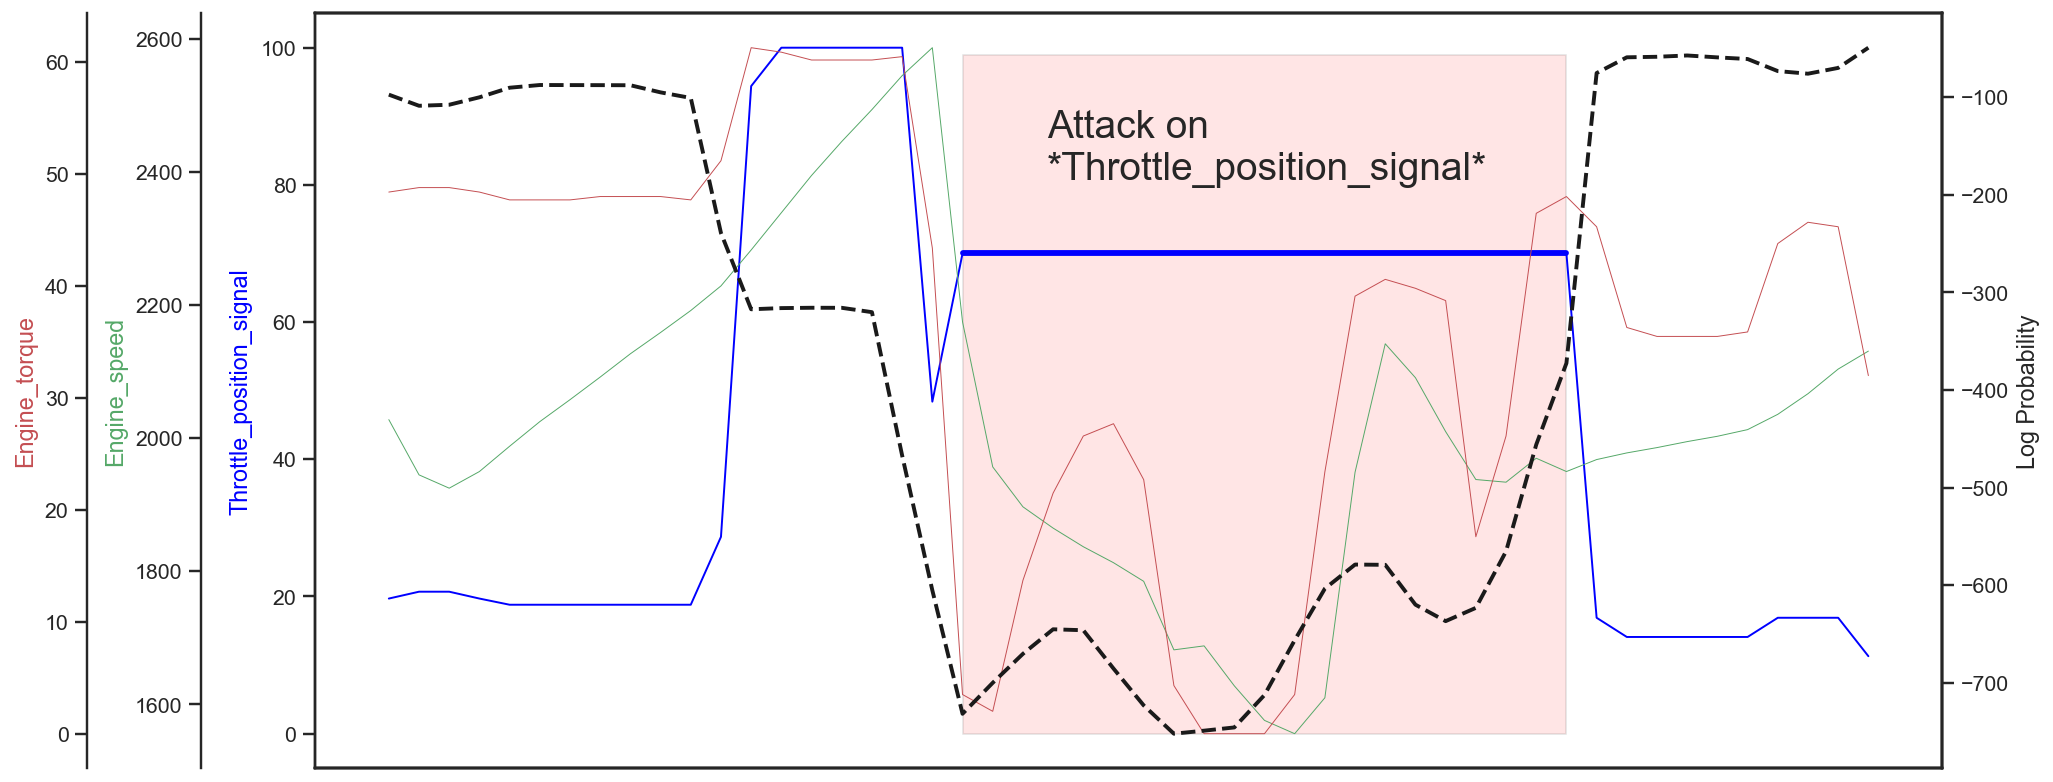

In [15]:
k=0
n=50

f = plt.figure(figsize=(15, 7))

attack_subset = x_test_attack[k:n].loc[y_test_attack[k:n][y_test_attack==1].index, :]

# plot attacked signal
ax_throttle = sns.lineplot(x=x_test_attack.index[k:n], y=x_test_attack['Throttle_position_signal'][k:n], color='blue', lw=1)
ax_throttle.yaxis.label.set_color('blue')
ax_throttle.set_xticklabels([])

# highlight attack region
sns.lineplot(x=attack_subset.index, y=attack_subset['Throttle_position_signal'], color='blue', lw=3)
ax_throttle.text(0.45, 0.78, 'Attack on\n*Throttle_position_signal*', transform=ax_throttle.transAxes, fontsize=20)
ax_throttle.fill_betweenx(range(0, 100), x1=attack_subset.index[0], x2=attack_subset.index[-1], facecolor='red', edgecolor='k', alpha=0.1)

# plot torque and speed signals
ax_engine = ax_throttle.twinx()
ax_engine.spines['left'].set_visible('True')
ax_engine.yaxis.set_label_position('left')
ax_engine.yaxis.set_ticks_position('left')
ax_engine.spines.left.set_position(('axes', -.07))
ax_engine.yaxis.label.set_color('g')

ax_torque = ax_throttle.twinx()
ax_torque.spines['left'].set_visible('True')
ax_torque.yaxis.set_label_position('left')
ax_torque.yaxis.set_ticks_position('left')
ax_torque.spines.left.set_position(('axes', -.14))
ax_torque.yaxis.label.set_color('r')

sns.lineplot(x=x_test_attack.index[k:n], y=x_test_attack['Engine_speed'][k:n],  lw=.5, color='g', ax=ax_engine)
sns.lineplot(x=x_test_attack.index[k:n], y=x_test_attack['Engine_torque'][k:n], lw=.5, color='r', ax=ax_torque)

# Plot probability line
ax_prob = ax_throttle.twinx()
ax_prob.set_axisbelow(True)
# ax_prob.grid(True)
ax_prob.set_ylabel('Log Probability')
sns.lineplot(x=y_test_pred.index[k:n], y=log_probs[k:n], ax=ax_prob, color='k', linestyle='--', lw=2)